Dette dokumentet forklarer bruken av BB_data funksjonen brukt for å hente effekt envelopen til et lydsignal. Dette gjøres ved kvadrering av hilbert transformen til signalet, deretter en rekke filtrering.

Figurene og teksten nedenfor tar for seg mye teori rundt moving average filtere og konvolusjon.

Poenget med dette dokumentet er å vise hvordan koden fungerer og hvordan den kan tas i bruk for live kalkulering av bredbånd data.

In [ ]:
def BB_data(sx, fs, sx_buff, hilbert_win, window_size):
    """
    PARAMETERS:
        sx: array of float
            Audio signal in time domain
        fs: int
            samplerate of sx
        sx_buff: array of float
            Buffered processed signal from last segment (Live implementation)
        hilbert_win: int
            No. of samples used for downsamlpling
        window_size: float
            No. of seconds used for filtering

    RETURN:
        BB_sig: array of float
            Logarithmic representation of power-envelope
        t: array of float
            time array corresponding to BB_sig
        sx_buff_out: array of float
            Buffered processed signal from last segment (Live implementation)
    """
    # Apply Hilbert transform to the signal, take the absolute value, square the result (power envelope), and then apply a median filter
    # to smooth the squared analytic signal. The window size for the median filter is defined by `medfilt_window`.
    envelope = moving_average_padded(np.square(np.abs(hilbert(sx))),hilbert_win)

    # Downsample the filtered signal
    DS_Sx = resample_poly(envelope, 1, hilbert_win)  # Resample by the median filter window size
    DS_Fs = fs / hilbert_win  # New sampling rate after downsampling

    # Define kernel size for the median filter based on window size
    kernel_size = int(window_size * DS_Fs) | 1  # Ensure odd size
    signal_med = moving_average_zero_padded(DS_Sx, kernel_size)  # Apply median filter for further noise removal

    #Removing invalid values
    signal_med = signal_med[kernel_size//2:-kernel_size//2]

    #Adding last of previous to start
    signal_med[:len(sx_buff)] += sx_buff

    #Preparing buffer for next segment
    sx_buff_out = signal_med[-kernel_size:]

    #Cutting end of current
    signal_med = signal_med[:-kernel_size]


    BB_sig = 10*np.log10(signal_med)
    t = np.linspace(0,len(BB_sig)/DS_Fs,len(BB_sig))
    return BB_sig, t, sx_buff_out



def moving_average_zero_padded(signal, window_size=5):
    pad_size = window_size // 2
    padded_signal = np.pad(signal, pad_size, mode="constant",constant_values=0)  # Repeat edge values
    kernel = np.ones(window_size) / window_size
    smoothed = np.convolve(padded_signal, kernel, mode="full")  # Only keep valid parts
    return smoothed

Funksjonen BB_data er designet for å prosessere rå lyddata over til et effektsignal, dette gjøres ved å ekstrahere envelopen til lydsignalet via abs(hilbert()) finksjonen. Deretter kvadreres signalet for å få effekten til signalet.

Etter envelopen er ekstrahert kreves nedsampling og rafinering av signalet for å unngå sløsing av datakraft og unødvendig stor bruk av lagringsplass.

For filtreringen brukes moving_average_zero_padded(), denne funksjonen er et moving average konvolusjon filter med zero padding på hver side. En konsekvens til dette filteret er rand effekter. Å padde signalet med 0´er på side før et average filter vil føre til at kantene på signalet faller sakte ned. Se illutrasjon under.

Text(0.5, 0, 't [s]')

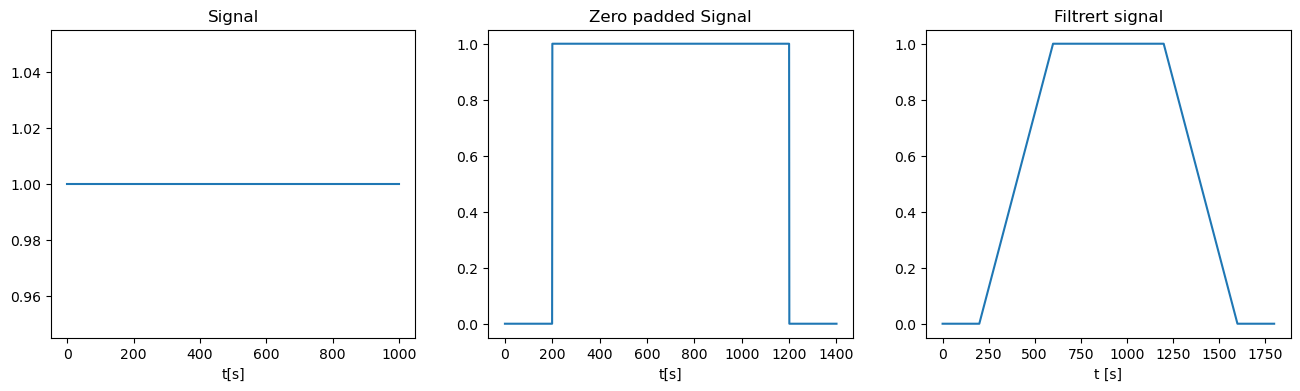

In [21]:
import numpy as np
import matplotlib.pyplot as plt

signal = np.ones(1000) #signal laget av 1´ere (rett linje)

window_size = 400 #Filter bredde i samples

pad_size = window_size // 2
padded_signal = np.pad(signal, pad_size, mode="constant",constant_values=0)  # Padder hver side med pad_size antall 0´er 
kernel = np.ones(window_size) / window_size  #Filter koeffisienter 
smoothed = np.convolve(padded_signal, kernel, mode="full")  # Kjører moving average filter over signalet

fig = plt.figure(figsize=(16,4))

plt.subplot(1,3,1)
t = np.linspace(0,len(signal),len(signal))
plt.plot(t,signal)
plt.xlabel("t[s]")
plt.title("Signal")
plt.subplot(1,3,2)
padded_t = np.linspace(0,len(padded_signal),len(padded_signal))
plt.plot(padded_t,padded_signal)
plt.xlabel("t[s]")
plt.title("Zero padded Signal")
plt.subplot(1,3,3)
smoothed_t = np.linspace(0,len(smoothed),len(smoothed))
plt.plot(smoothed_t,smoothed)
plt.title("Filtrert signal")
plt.xlabel("t [s]")



Legg også merke til hvordan signalet blir lengere og lengere for hver operasjon. Siden padding og filtereffekter er symmetriske vet vi at informasjonen fra det originale signalet ligger sentrert, så alt som trengs er å klippe bort uønskede ender av signalet, nesten.

    Vi noterer:
len(signal) = N

    Med window_size Zero padding får vi:
len(padded_signal) = N + window_size

    Konvolusjon:
len(smoothed)   = len(padded_signal) + len(kernel) - 1 \
                = (N + window_size) + window_size - 1 \
                = N + 2 * window_size - 1 

eks:
Med verdier fra koden over har vi.
N = 1000
window_size = 400

=> len(smoothed) = 1000 + 2* 400 -1 = 1799


Delen av signalet som blir lagt til av konvolusjonen helt til slutt i prosesseringen, de flate endekantene, bærer ingen ny brukbar informasjon for denne type bruk. Derfor kan de ytterste bitene fra begge sider kuttes. Se bilde under

Regionen hvor zero paddingen ble lagt til derimot innehar informasjon til det orginale signalet og må tas vare på. 

Dette fører til at signalet nå se slik ut:


Text(0.5, 0, 't [s]')

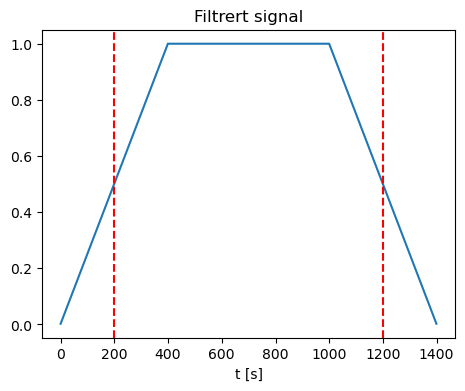

In [20]:
import numpy as np
import matplotlib.pyplot as plt

signal = np.ones(1000) #signal laget av 1´ere (rett linje)

window_size = 400 #Filter bredde i samples

pad_size = window_size // 2
padded_signal = np.pad(signal, pad_size, mode="constant",constant_values=0)  # Padder hver side med pad_size antall 0´er 
kernel = np.ones(window_size) / window_size  #Filter koeffisienter 
smoothed = np.convolve(padded_signal, kernel, mode="full")  # Kjører moving average filter over signalet

fig = plt.figure(figsize=(16/3,4))

smoothed = smoothed[window_size//2:-window_size//2]

smoothed_t = np.linspace(0,len(smoothed),len(smoothed))
plt.plot(smoothed_t,smoothed)
plt.axvline(x = window_size//2, color="red", linestyle="--")
plt.axvline(x = len(smoothed) - window_size//2, color="red", linestyle="--")
plt.title("Filtrert signal")
plt.xlabel("t [s]")

Legg merke til at lengden av dette prosesserte signalet nå er lengere enn da vi begynnte, plasseringen av det orginale signalet er markert mellom de røde linjene i figuren over.
Signalet er nå "flyttet fram i tid", orginal signalets start og slutt er markert ved de røde linjene så alt som ligger på utsiden av disse linjene er ikke "reelle" signal, men innehar fremdeles mye informasjon.

For å rette opp i dette kan en begynne med å flytte signalet tilbake i tid:

Text(0.5, 0, 't [s]')

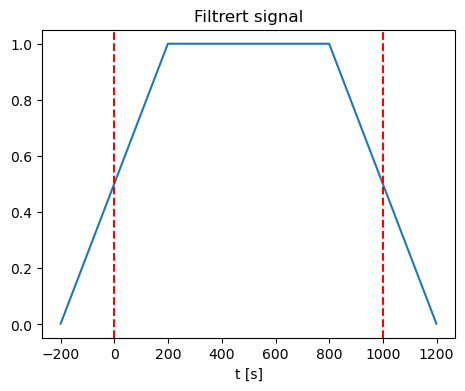

In [23]:
import numpy as np
import matplotlib.pyplot as plt

signal = np.ones(1000) #signal laget av 1´ere (rett linje)

window_size = 400 #Filter bredde i samples

pad_size = window_size // 2
padded_signal = np.pad(signal, pad_size, mode="constant",constant_values=0)  # Padder hver side med pad_size antall 0´er 
kernel = np.ones(window_size) / window_size  #Filter koeffisienter 
smoothed = np.convolve(padded_signal, kernel, mode="full")  # Kjører moving average filter over signalet

fig = plt.figure(figsize=(16/3,4))

smoothed = smoothed[window_size//2:-window_size//2]

smoothed_t = np.linspace(0,len(smoothed),len(smoothed))
plt.plot(smoothed_t-window_size//2,smoothed)
plt.axvline(x = 0, color="red", linestyle="--")
plt.axvline(x = len(smoothed) - window_size, color="red", linestyle="--")
plt.title("Filtrert signal")
plt.xlabel("t [s]")

Formålet med BB_data funksjonen er å lage et plot for effekt envelopen til signalet under et live opptak. For behandling av ferdige lyddata er koden ferdig så langt, det eneste som gjenstår er å kutte kantene på signalet.

Denne funkjsonen skal brukes live og skal kunne gi samme resultat for et ferdig opptak og for et segmentert lydopptak. Derfor passer det velig bra at signalet sklir litt fram og tilbake i tid.

La oss nå prøve å sende to signal igjennom prosesseringen, men de er splittet opp og prosessert en og en.

Text(0.5, 0, 't [s]')

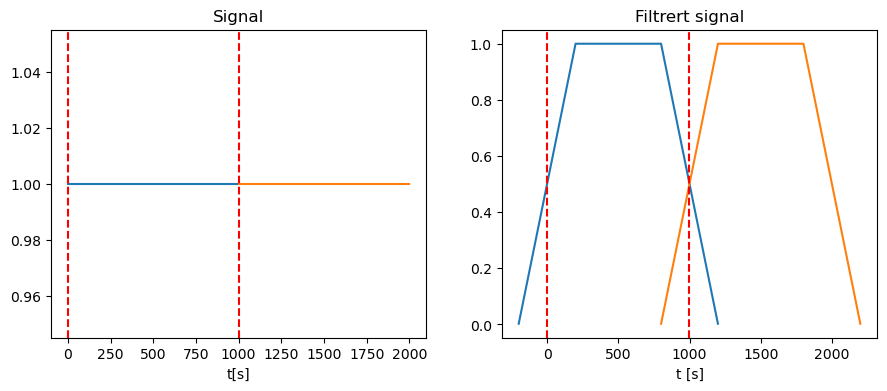

In [32]:
import numpy as np
import matplotlib.pyplot as plt

signal = np.ones(1000) #signal laget av 1´ere (rett linje)

window_size = 400 #Filter bredde i samples

pad_size = window_size // 2
padded_signal = np.pad(signal, pad_size, mode="constant",constant_values=0)  # Padder hver side med pad_size antall 0´er 
kernel = np.ones(window_size) / window_size  #Filter koeffisienter 
smoothed = np.convolve(padded_signal, kernel, mode="full")  # Kjører moving average filter over signalet

fig = plt.figure(figsize=(16*2/3,4))



smoothed = smoothed[window_size//2:-window_size//2]
plt.subplot(1,2,1)
t = np.linspace(0,len(signal),len(signal))
plt.plot(t,signal)
plt.plot(t+1000,signal)
plt.axvline(x = 0, color="red", linestyle="--")
plt.axvline(x = 1000, color="red", linestyle="--")
plt.xlabel("t[s]")
plt.title("Signal")
plt.subplot(1,2,2)
smoothed_t = np.linspace(0,len(smoothed),len(smoothed))
plt.plot(smoothed_t-window_size//2,smoothed)
plt.plot(smoothed_t + 1000 - window_size//2, smoothed)
plt.axvline(x = 0, color="red", linestyle="--")
plt.axvline(x = len(smoothed) - window_size, color="red", linestyle="--")
plt.title("Filtrert signal")
plt.xlabel("t [s]")

Det vises klart at signalet sklir langt nok tilbake i tid til å dekke hele området påvirket av randeffektene til filteret. Signalene blir "dratt" ned mot null med lik hastighet over lik tid på hver side, siden parameterene beholdes like for hvert prsesserte segment. For å fikse randeffektene må de overlappende randene summeres, denne metoden kalles "Overlap-Add (OLA)".

Dette fører til at signalet nå ser slik ut:

Text(0.5, 0, 't [s]')

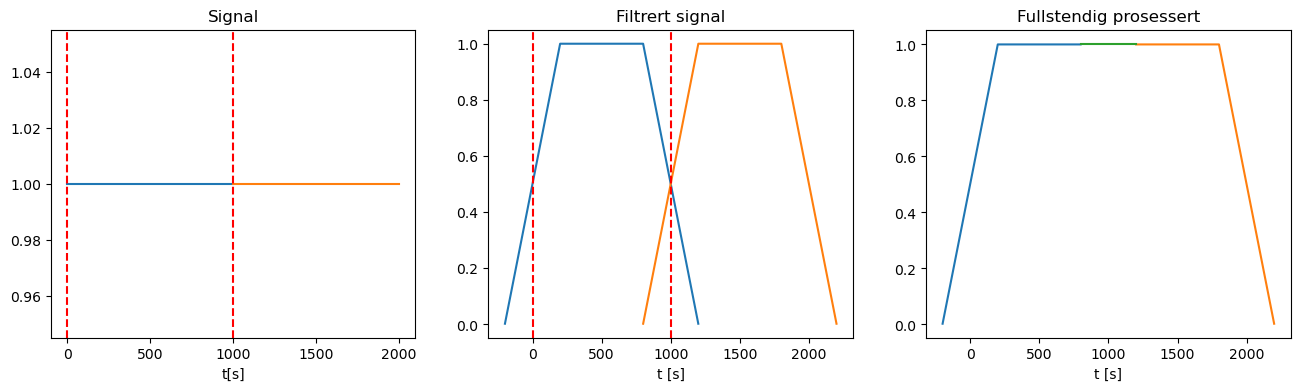

In [49]:
import numpy as np
import matplotlib.pyplot as plt

signal = np.ones(1000) #signal laget av 1´ere (rett linje)

window_size = 400 #Filter bredde i samples

pad_size = window_size // 2
padded_signal = np.pad(signal, pad_size, mode="constant",constant_values=0)  # Padder hver side med pad_size antall 0´er 
kernel = np.ones(window_size) / window_size  #Filter koeffisienter 
smoothed = np.convolve(padded_signal, kernel, mode="full")  # Kjører moving average filter over signalet

fig = plt.figure(figsize=(16,4))



smoothed = smoothed[window_size//2:-window_size//2]
plt.subplot(1,3,1)
t = np.linspace(0,len(signal),len(signal))
plt.plot(t,signal)
plt.plot(t+1000,signal)
plt.axvline(x = 0, color="red", linestyle="--")
plt.axvline(x = 1000, color="red", linestyle="--")
plt.xlabel("t[s]")
plt.title("Signal")

plt.subplot(1,3,2)
smoothed_t = np.linspace(0,len(smoothed),len(smoothed))
plt.plot(smoothed_t-window_size//2,smoothed)
plt.plot(smoothed_t + 1000 - window_size//2, smoothed)
plt.axvline(x = 0, color="red", linestyle="--")
plt.axvline(x = len(smoothed) - window_size, color="red", linestyle="--")
plt.title("Filtrert signal")
plt.xlabel("t [s]")

plt.subplot(1,3,3)
smoothed_t = np.linspace(0,len(smoothed),len(smoothed))
plt.plot((smoothed_t-window_size//2)[:-window_size],smoothed[:-window_size])
plt.plot((smoothed_t + 1000 - window_size//2)[window_size:], smoothed[window_size:])
plt.plot((smoothed_t-window_size//2)[-window_size:],smoothed[-window_size:]+smoothed[:window_size])
plt.title("Fullstendig prosessert")
plt.xlabel("t [s]")

For å kunne summere randen til signalene uten å forsinke systemet ved å ta inn to segmenter hvor hver gang velges en feedback løsning.
Siden kun randen skal summeres klippes høyre ende av hvert signal, denne enden lagres i en buffer og sendes ut av BB_data funksjonen sammen med resten av dataen. Når neste segment sendes inn for behandling skal siste ende del av forrige signal også sendes inn, da vil randene summeres og signalet er fikset i skiktet mellom segmentene. Så kuttes slutten og sendes tilbake sammen med neste segment igjen.

Denne løsningen sørger for minst mulig forsinkelse i systemet med høyest kvalitet.

Under er et eksempel på bruk av denne funksjonen i en "live" sammenheng. Koden sender et og et segment av lyddata igjennom BB_data om gangen i en løkke, dette sørger for å mate tilbake bufferen samtidig som det etterligner live bruk.

Parameterene:   _len, hilbert_win, window_size

Disse parameterere står fritt til å endres, gjør deg kjent ved å endre de og se hvordan plottet endres.

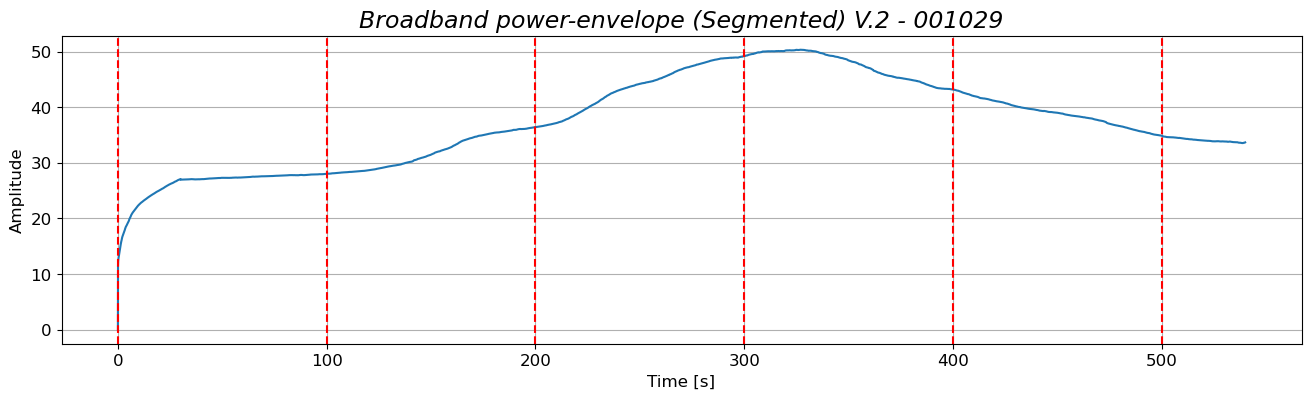

In [ ]:
import functions
import matplotlib.pyplot as plt
import numpy as np

fs = 10000
_len = 100 #lengde på hvert segment i sekunder
hilbert_win=15
window_size=30 #Lengde på konvolusjon filter i sekunder

input_path = "Sound_data/001029.wav"
sx, fs = functions.load_audiofile(input_path, fs, 5, True) #Laster inn lyddata
t = np.linspace(0,len(sx)/fs,len(sx))

fig = plt.figure(figsize=(16,4))
BB2 = [] #Initialiserer buffer for Bredbånd data

sx_buffer = [] #Initialiserer tomt buffer
for k in range(0,int(len(sx)/fs),_len): #Sender lyddata delt opp i segmenter
    BB_current, BB_t, sx_buffer = functions.BB_data(sx[k*fs:((_len+k)*fs)],fs,sx_buffer,hilbert_win,window_size)
    BB2 = np.append(BB2,BB_current) #Legger bredbånddata i buffer

BB2 = BB2 - np.min(BB2) #Justerer nullpunkt for plot
BB_t2 = np.linspace(0,len(BB2)*hilbert_win/fs,len(BB2)) #arbitrær tidsakse
plt.plot(BB_t2, BB2)

for k in range(0,int(len(sx)/fs),_len):
    plt.axvline(x=k,color="red",linestyle="--") #Viser røde linjer i plot for segmentering

plt.xlabel("Time [s]",fontsize=12)
plt.ylabel("Amplitude",fontsize=12)
plt.title("Broadband power-envelope (Segmented) V.2 - 001029",fontsize=17, style='italic')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)

Merk at mye av forklaringene ovenfor fokuserer på parametere for filtrering og at forskjellige lokale variabler kan ha samme navn.

Parameterene for BB_data er som følger:


    PARAMETERS:
        sx: array of float
            Audio signal in time domain
        fs: int
            samplerate of sx
        sx_buff: array of float
            Buffered processed signal from last segment (Live implementation)
        hilbert_win: int
            No. of samples used for downsamlpling
        window_size: float
            No. of seconds used for filtering

    RETURN:
        BB_sig: array of float
            Logarithmic representation of power-envelope
        t: array of float
            time array corresponding to BB_sig
        sx_buff_out: array of float
            Buffered processed signal from last segment (Live implementation)


INTENDED USAGE:

Forventet bruk av denne funksjonen er å sende inn et og et segment av lyddata. For hver gang funksjonen kjøres returneres bredbånddata (klar for plotting), en arbitrær tidsakse og en "buffer" (sx_buff_out), denne skal mates tilbake inn i funksjonen sammen med neste segment.

For initialisering av systemet, første segment, holder det å mate inn et tomt array av verdier.
